In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import easygems.healpix as egh
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colorbar import ColorbarBase

# define paths
datapath = '/g/data/qx55/germany_node/d3hp003.zarr'
file = 'P1D_mean'
zoom = 'z5'

# define the fname
fpath = f'{datapath}/{file}_{zoom}_atm.zarr'

# open the zarr file
ds = xr.open_zarr(fpath)

#### some variables of interest ####

**hfssd**: sensible heat flux  
**hflsd**: latent heat flux  
**huss**: specific humidity in 2m  
**mrso**: Water content of soil layers  
**orog**: surface altitude  
**pr**: precipitation flux  
**rlds**: surface downwelling longwave radiation  
**rldscs**: surface downwelling clear-sky longwave radiation  
**rlus**: surface upwelling longwave radiation  
**rsds**: surface downwelling shortwave radiation  
**rsdscs**: surface downwelling clear-sky shortwave radiation  
**rsus**: surface upwelling shortwave radiation  
**sftlf**: cell area fraction occupied by land including lakes  
**tas**: temperature in 2m  
**tauu**: u-momentum flux at the surface  
**tauv**: v-momentum flux at the surface  
**ts**: surface temperature  
**uas**: zonal wind in 10m  
**vas**: meridional wind in 10m  

In [ ]:
# get cell area fraction of land
land_frac = ds['sftlf']

<xarray.DataArray 'sftlf' (cell: 12288)> Size: 49kB
dask.array<open_dataset-sftlf, shape=(12288,), dtype=float32, chunksize=(12288,), chunktype=numpy.ndarray>
Dimensions without coordinates: cell
Attributes:
    grid_mapping:        crs
    hiopy::time_method:  point
    hiopy::nnn:          4
    hiopy::enable:       True
    standard_name:       land_area_fraction
    units:               m2/m2
    short_name:          
    long_name:           cell area fraction occupied by land including lakes

In [60]:

# get variables to plot
soil_moisture = ds['mrso'].isel(soil_level=0).mean('time')
precip = ds['pr'].mean('time')
latent_heat = ds['hflsd'].mean('time')

# convert precip from mm/s to mm/day
precip = precip*86400

# apply mask
soil_moisture = soil_moisture.where(land_frac>0.9).where(precip>0.1)
precip = precip.where(land_frac>0.9).where(precip>0.1)
latent_heat = latent_heat.where(land_frac>0.9).where(precip>0.1)

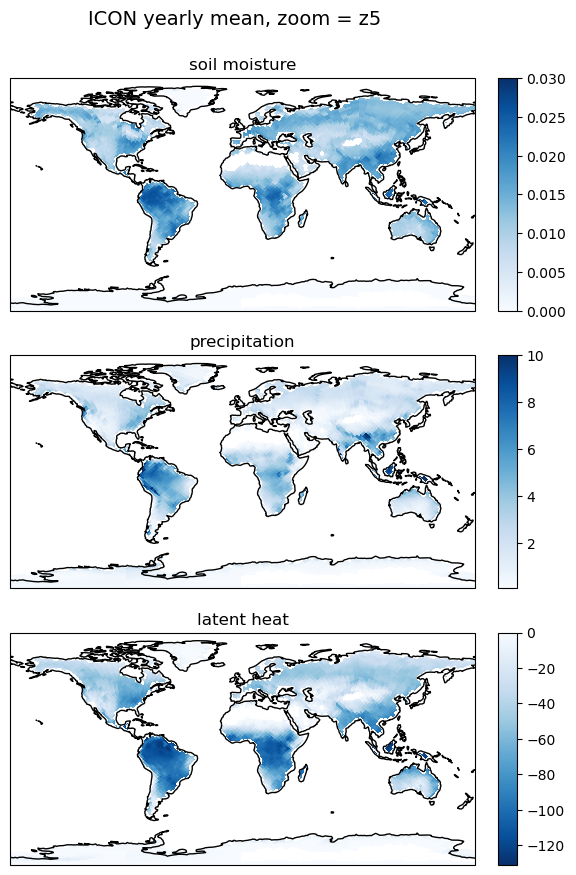

In [64]:
# test plot some data
plt.close('all')
projection=ccrs.PlateCarree(central_longitude=0.0)
fig, axes = plt.subplots(3, 1, figsize=(6, 12), subplot_kw={'projection': projection})

titles = ['soil moisture', 'precipitation', 'latent heat']
cmaps = ['Blues','Blues','Blues_r']
vmaxs = [0.03,10,0]

for ax, data, title, cmap, vmax in zip(axes.flatten(), [soil_moisture, precip, latent_heat], 
                           titles,cmaps,vmaxs):
    
    ax.set_global()
    im = egh.healpix_show(data.values,ax=ax,cmap=cmap,vmax=vmax)
    ax.set_title(title)
    ax.coastlines()
    # ax.gridlines(draw_labels=True)

    # colorbar
    cax = inset_axes(ax,
    width='4%',  # % of parent_bbox width
    height='100%',
    loc='lower left',
    bbox_to_anchor=(1.05, 0, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
    )
    cbar = ColorbarBase(cax, cmap=im.cmap, norm = im.norm, ticks = None)

fig.subplots_adjust(hspace=-0.25)
fig.suptitle(f'ICON yearly mean, zoom = {zoom}',y=0.88, fontsize=14)
plt.show()